In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost
from xgboost import XGBClassifier
from sklearn.externals import joblib
from sklearn.preprocessing import RobustScaler

In [3]:
#merging for BDT training
node_6=pd.read_hdf("node_6.hd5")
node_9=pd.read_hdf("node_9.hd5")
node_4=pd.read_hdf("node_4.hd5")
node_SM=pd.read_hdf("node_SM.hd5")

frames=[node_6,node_9,node_4,node_SM]
df=pd.concat(frames)

#indexing
random_index = np.arange(df.shape[0]) 
np.random.shuffle(random_index)
df["random_index"]=random_index 
df.set_index("random_index",inplace=True)
df.sort_index(inplace=True)

In [4]:
df.columns

Index([u'candidate_id', u'weight', u'mgg', u'mbb', u'leadPho_px',
       u'leadPho_py', u'leadPho_pz', u'leadPho_e', u'subleadPho_px',
       u'subleadPho_py', u'subleadPho_pz', u'subleadPho_e', u'leadJet_px',
       u'leadJet_py', u'leadJet_pz', u'leadJet_e', u'subleadJet_px',
       u'subleadJet_py', u'subleadJet_pz', u'subleadJet_e', u'rho', u'nvtx',
       u'event', u'lumi', u'processIndex', u'run', u'npu', u'puweight', u'cat',
       u'bdtcat', u'mxcat', u'leadPho_pt', u'leadPho_eta', u'leadPho_phi',
       u'leadPho_m', u'subleadPho_pt', u'subleadPho_eta', u'subleadPho_phi',
       u'subleadPho_m', u'leadJet_pt', u'leadJet_eta', u'leadJet_phi',
       u'leadJet_m', u'subleadJet_pt', u'subleadJet_eta', u'subleadJet_phi',
       u'subleadJet_m', u'hgg_px', u'hgg_py', u'hgg_pz', u'hgg_e', u'hgg_pt',
       u'hgg_eta', u'hgg_phi', u'hgg_m', u'hbb_px', u'hbb_py', u'hbb_pz',
       u'hbb_e', u'hbb_pt', u'hbb_eta', u'hbb_phi', u'hbb_m', u'hh_px',
       u'hh_py', u'hh_pz', u'hh_e', u'hh

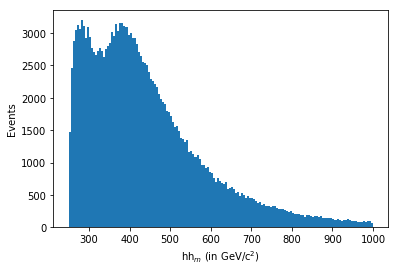

In [5]:
plt.figure(1)
plt.hist(df['hh_m'],range=[250,1000],bins=150)
plt.ylabel("Events")
plt.xlabel("hh$_m$ (in GeV/c$^2$)")
plt.show()
plt.close()

In [6]:
features = ['hh_m','hh_pt', 'hh_eta','hgg_pt_hh_m','hbb_pt_hh_m','cos_theta_cs','cos_theta_hbb','cos_theta_hgg']
features+=['leadJet_pt','leadJet_eta','subleadJet_pt','subleadJet_eta']
features+=['leadPho_pt','leadPho_eta','subleadPho_pt','subleadPho_eta']

In [7]:
#finding sum, count, mean of each category in weights column
df.groupby('cat')['weight'].agg(['sum','count','mean'])

,sum,count,mean
cat,,,
0,2.971749,148936,0.000020
1,0.159532,8433,0.000019
2,0.152647,8202,0.000019
3,0.051188,2788,0.000018
4,0.013646,750,0.000018
5,0.030381,1523,0.000020
6,0.054648,2868,0.000019
7,0.041555,2245,0.000019
8,0.019401,1077,0.000018


In [8]:
X = df[features]
y = df['cat'] 
w = df['weight']

scaler=RobustScaler()

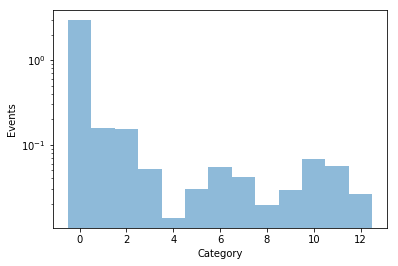

In [9]:
#plotting truth histogram (weighted histogram of categories with logarithmic y scale)
plt.figure(2)
plt.hist(y,weights=w,bins=13,range=[-0.5,12.5],alpha=0.5)
plt.ylabel('Events')
plt.xlabel('Category')
plt.yscale('log')
plt.show()
plt.close()

In [10]:
#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12345)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

X_test.to_hdf("X_test.hd5",key='df',mode="w")
y_test.to_hdf("y_test.hd5",key='df',mode="w")
w_test.to_hdf("w_test.hd5",key='df',mode="w")
X_train.to_hdf("X_train.hd5",key='df',mode="w")
y_train.to_hdf("y_train.hd5",key='df',mode="w")
w_train.to_hdf("w_train.hd5",key='df',mode="w")

#classifier fitted to training set 
clf=XGBClassifier(max_depth=10, n_estimators=300, n_jobs=8, objective='multi:softmax', subsample=0.8)
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf.joblib') 

CPU times: user 4min 53s, sys: 8.5 s, total: 5min 2s
Wall time: 37.9 s


['clf.joblib']

In [11]:
#reweighting and clipping it at 50

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12346)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

X_test.to_hdf("X_test_50.hd5",key='df',mode="w")
y_test.to_hdf("y_test_50.hd5",key='df',mode="w")
w_test.to_hdf("w_test_50.hd5",key='df',mode="w")

h=np.histogram(y_train,weights=w_train,bins=13,range=[-0.5,12.5])
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,50)
w_train*=rw[y_train]

np.savetxt('rw_50.txt',rw)

clf=XGBClassifier(max_depth=10, n_estimators=300, n_jobs=8, objective='multi:softmax', subsample=0.8)
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_50.joblib') 

CPU times: user 6min 14s, sys: 7.28 s, total: 6min 22s
Wall time: 47.8 s


['clf_50.joblib']

In [12]:
#reweighting and clipping it at 25

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12347)
w_train = np.abs(w_train)

X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

X_test.to_hdf("X_test_25.hd5",key='df',mode="w")
y_test.to_hdf("y_test_25.hd5",key='df',mode="w")
w_test.to_hdf("w_test_25.hd5",key='df',mode="w")

h=np.histogram(y_train,weights=w_train,bins=13,range=[-0.5,12.5])
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,25)
w_train*=rw[y_train]

np.savetxt('rw_25.txt',rw)

clf=XGBClassifier(max_depth=10, n_estimators=300, n_jobs=8, objective='multi:softmax', subsample=0.8)
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_25.joblib') 

CPU times: user 4min 32s, sys: 6.2 s, total: 4min 38s
Wall time: 34.9 s


['clf_25.joblib']

In [13]:
#reweighting and clipping it at 10

#slicing data randomly into training and testing sets- we take 20% to be the testing set
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12348)
w_train = np.abs(w_train)

#scale data
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

X_test.to_hdf("X_test_10.hd5",key='df',mode="w")
y_test.to_hdf("y_test_10.hd5",key='df',mode="w")
w_test.to_hdf("w_test_10.hd5",key='df',mode="w")

h=np.histogram(y_train,weights=w_train,bins=13,range=[-0.5,12.5])
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,10)
w_train*=rw[y_train]

np.savetxt('rw_10.txt',rw)

clf=XGBClassifier(max_depth=10, n_estimators=300, n_jobs=8, objective='multi:softmax', subsample=0.8)
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_10.joblib') 

CPU times: user 5min 7s, sys: 9.34 s, total: 5min 16s
Wall time: 39.7 s


['clf_10.joblib']

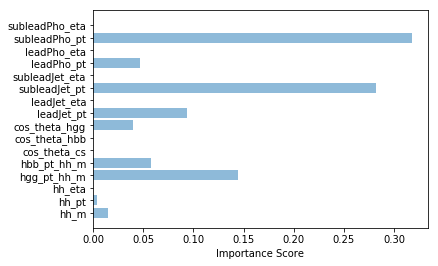

In [14]:
#features importance
clf=joblib.load('clf_10.joblib')
importance=clf.feature_importances_
y_pos=np.arange(len(features))
plt.barh(y_pos,importance,align='center',alpha=0.5)
plt.yticks(y_pos,features)
plt.xlabel('Importance Score')
plt.show()

In [15]:
#reweighting and clipping it at 75

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12349)
w_train = np.abs(w_train)

X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

X_test.to_hdf("X_test_75.hd5",key='df',mode="w")
y_test.to_hdf("y_test_75.hd5",key='df',mode="w")
w_test.to_hdf("w_test_75.hd5",key='df',mode="w")

h=np.histogram(y_train,weights=w_train,bins=13,range=[-0.5,12.5])
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,75)
w_train*=rw[y_train]

np.savetxt('rw_75.txt',rw)

clf=XGBClassifier(max_depth=10, n_estimators=300, n_jobs=8, objective='multi:softmax', subsample=0.8)
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_75.joblib') 

CPU times: user 7min 1s, sys: 7.19 s, total: 7min 8s
Wall time: 53.7 s


['clf_75.joblib']

In [16]:
#reweighting and clipping it at 90

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2,random_state=12350)
w_train = np.abs(w_train)

X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

X_test.to_hdf("X_test_90.hd5",key='df',mode="w")
y_test.to_hdf("y_test_90.hd5",key='df',mode="w")
w_test.to_hdf("w_test_90.hd5",key='df',mode="w")

h=np.histogram(y_train,weights=w_train,bins=13,range=[-0.5,12.5])
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,90)
w_train*=rw[y_train]

np.savetxt('rw_90.txt',rw)

clf=XGBClassifier(max_depth=10, n_estimators=300, n_jobs=8, objective='multi:softmax', subsample=0.8)
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_90.joblib')

CPU times: user 8min 2s, sys: 12.2 s, total: 8min 14s
Wall time: 1min 1s


['clf_90.joblib']

In [17]:
opt_accu=pd.read_hdf("optimisation_accu.hd5")
print "Best accuracy"
print opt_accu[0:3]

Best accuracy
    clip_weight  learning_rate  max_depth  n_estimators  reg_lambda  \
35           20            0.5          3           500         0.5   
36           10            0.3         10           300        10.0   
10           30            0.3          5           300         2.0   

    subsample  accu_mean  accu_stdev  cross_mean  cross_stdev  
35        0.8   0.499177    0.002681    1.625926     0.005704  
36        0.8   0.496811    0.001754    1.681311     0.005318  
10        1.0   0.471232    0.002489    1.816118     0.005555  


In [21]:
opt_cross=pd.read_hdf("optimisation_cross.hd5")
print "Best entropy"
print opt_cross[0:3]

Best entropy
    clip_weight  learning_rate  max_depth  n_estimators  reg_lambda  \
35           20            0.5          3           500         0.5   
36           10            0.3         10           300        10.0   
55           40            0.5          5           500         0.1   

    subsample  accu_mean  accu_stdev  cross_mean  cross_stdev  
35        0.8   0.499177    0.002681    1.625926     0.005704  
36        0.8   0.496811    0.001754    1.681311     0.005318  
55        1.0   0.460051    0.003765    1.801694     0.008230  


In [22]:
#optimized

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X,y,w,test_size=0.2, random_state=12351)
w_train = np.abs(w_train)

X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

X_test.to_hdf("X_test_opt.hd5",key='df',mode="w")
y_test.to_hdf("y_test_opt.hd5",key='df',mode="w")
w_test.to_hdf("w_test_opt.hd5",key='df',mode="w")
 
h=np.histogram(y_train,weights=w_train,bins=13,range=[-0.5,12.5])
a=1./h[0]
a/=min(a)
rw=np.clip(a,0,20)
w_train*=rw[y_train]

np.savetxt('rw_opt.txt',rw)

clf=XGBClassifier(max_depth=3, n_estimators=500, n_jobs=8, objective='multi:softmax', subsample=0.8,
                 reg_lambda=0.5, learning_rate=0.5)
%time clf.fit(X_train,y_train,w_train)
joblib.dump(clf, 'clf_opt.joblib') 

CPU times: user 9min 4s, sys: 14.1 s, total: 9min 18s
Wall time: 1min 9s


['clf_opt.joblib']

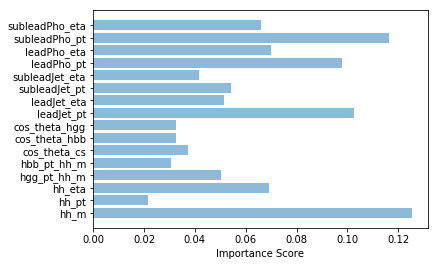

In [23]:
#features importance
clf=joblib.load('clf_opt.joblib')
importance=clf.feature_importances_
y_pos=np.arange(len(features))
plt.barh(y_pos,importance,align='center',alpha=0.5)
plt.yticks(y_pos,features)
plt.xlabel('Importance Score')
plt.show()